## UM atmosphere data loading and plotting with Iris

In [1]:
import os
import os.path

import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
from netCDF4 import Dataset
import scipy
import cartopy.crs as ccrs



In [2]:
TOP_LEVEL_DIRECTORY = "/gws/nopw/j04/eerie/public/data"

In [3]:
tas_files = [
    "EERIE/EERIE/MOHC/HadGEM3-GC5-EERIE-N640-ORCA12/eerie-piControl/r1i1p1f1/Amon/tas/gn/v20230928/tas_Amon_HadGEM3-GC5-EERIE-N640-ORCA12_eerie-piControl_r1i1p1f1_gn_185101-185112.nc",
    "EERIE/EERIE/MOHC/HadGEM3-GC5-EERIE-N640-ORCA12/eerie-piControl/r1i1p1f1/Amon/tas/gn/v20230928/tas_Amon_HadGEM3-GC5-EERIE-N640-ORCA12_eerie-piControl_r1i1p1f1_gn_185201-185212.nc",
    "EERIE/EERIE/MOHC/HadGEM3-GC5-EERIE-N640-ORCA12/eerie-piControl/r1i1p1f1/Amon/tas/gn/v20230928/tas_Amon_HadGEM3-GC5-EERIE-N640-ORCA12_eerie-piControl_r1i1p1f1_gn_185301-185312.nc",
    "EERIE/EERIE/MOHC/HadGEM3-GC5-EERIE-N640-ORCA12/eerie-piControl/r1i1p1f1/Amon/tas/gn/v20230928/tas_Amon_HadGEM3-GC5-EERIE-N640-ORCA12_eerie-piControl_r1i1p1f1_gn_185401-185412.nc",
    "EERIE/EERIE/MOHC/HadGEM3-GC5-EERIE-N640-ORCA12/eerie-piControl/r1i1p1f1/Amon/tas/gn/v20230928/tas_Amon_HadGEM3-GC5-EERIE-N640-ORCA12_eerie-piControl_r1i1p1f1_gn_185501-185512.nc"
]

In [4]:
tas_paths = [os.path.join(TOP_LEVEL_DIRECTORY, file_path) for file_path in tas_files]
tas_ds = xr.open_mfdataset(tas_paths)


In [5]:
tas_ds

<xarray.Dataset>
Dimensions:    (time: 60, bnds: 2, lat: 960, lon: 1280)
Coordinates:
  * time       (time) datetime64[ns] 1851-01-16T12:00:00 ... 1855-12-16T12:00:00
  * lat        (lat) float64 -89.91 -89.72 -89.53 -89.34 ... 89.53 89.72 89.91
  * lon        (lon) float64 0.1406 0.4219 0.7031 0.9844 ... 359.3 359.6 359.9
    height     float64 1.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(12, 960, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(12, 1280, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(12, 960, 1280), meta=np.ndarray>
Attributes: (12/39)
    Conventions:           CF-1.7 CMIP-6.2 UGRID-1.0
    activity_id:           EERIE
    branch_method:         no parent
    creation_date:         2023-10-03T14:46:10Z
    cv_version:            EERIE v0.1
    data_specs_version:    01.00.00
    ...                    ...
    tracking_id:           EERIE/f1bf937b-ab6b-495e-b368-1a73a322609f
    variable_id:           tas
    variable_name:         tas
    variant_label:         r1i1p1f1
    license:               EERIE data produced by MOHC is licensed under the ...
    cmor_version:          3.7.2

DataSet is a dict-like container of multiple DataArray (data variables) with aligned dimensions (coordinate variables).
In this instance, we would like to pick out the DataArray corresponding to "tas" under "Data variables"

In [6]:
tas_da = tas_ds["tas"]
tas_da

<xarray.DataArray 'tas' (time: 60, lat: 960, lon: 1280)>
dask.array<concatenate, shape=(60, 960, 1280), dtype=float32, chunksize=(12, 960, 1280), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1851-01-16T12:00:00 ... 1855-12-16T12:00:00
  * lat      (lat) float64 -89.91 -89.72 -89.53 -89.34 ... 89.53 89.72 89.91
  * lon      (lon) float64 0.1406 0.4219 0.7031 0.9844 ... 359.3 359.6 359.9
    height   float64 1.5
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2023-10-03T14:46:10Z altered by CMOR: Treated scalar dime...

We have now loaded the muliple netCDF files into a single DataArray. We can now do something interesting with this loaded data.

### Plotting time slices

Plot the first time point.

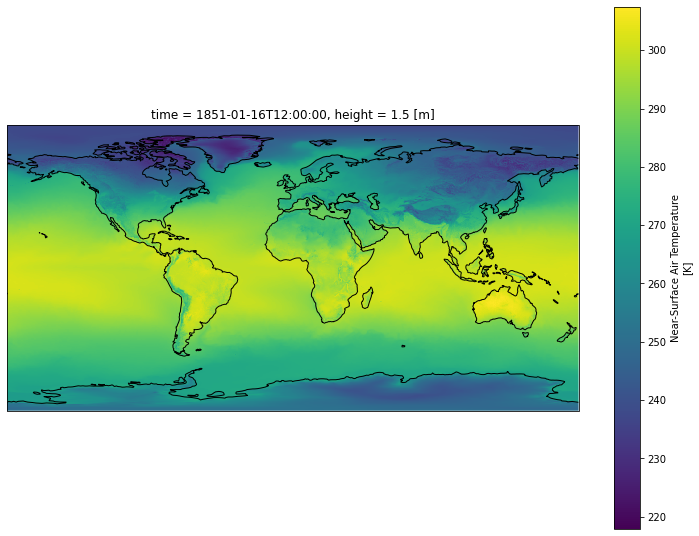

In [7]:
fig = plt.figure(figsize=[12.8, 9.6])
ax = plt.axes(projection=ccrs.PlateCarree())
tas_da.isel(time=0).plot()
ax.coastlines()
plt.draw()


### Time Mean

Plot time mean field

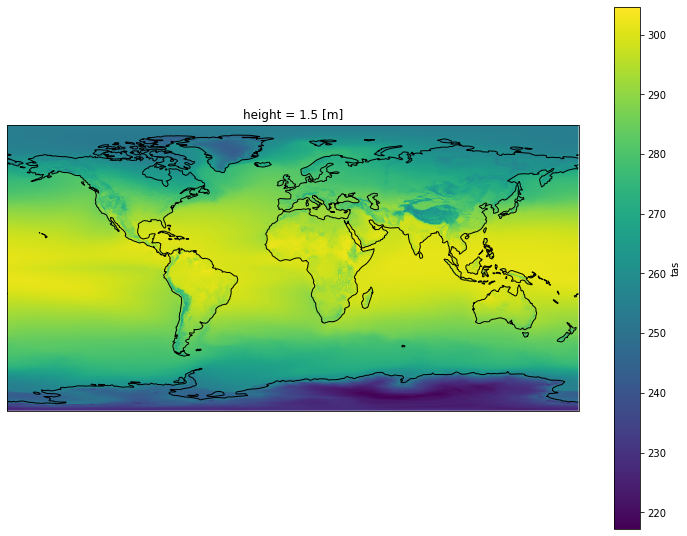

In [8]:
tas_time_mean = tas_da.mean(dim="time")

fig = plt.figure(figsize=[12.8, 9.6])
ax = plt.axes(projection=ccrs.PlateCarree())
tas_time_mean.plot()
ax.coastlines()
plt.draw()

### Area-weighted Time Series

Calculate the area weighted global mean at each time slice and plot this series.

In [10]:
weights = np.cos(np.deg2rad(tas_da.lat))
tas_weighted = tas_da.weighted(weights)
tas_global_mean = tas_weighted.mean(("lon", "lat"))
tas_global_mean

<xarray.DataArray 'tas' (time: 60)>
dask.array<truediv, shape=(60,), dtype=float64, chunksize=(12,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1851-01-16T12:00:00 ... 1855-12-16T12:00:00
    height   float64 1.5

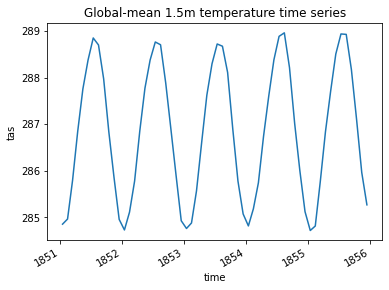

In [12]:
fig = plt.figure()
tas_global_mean.plot()
plt.title("Global-mean 1.5m temperature time series")
plt.draw()

### Regional map and time series

Plotting regional map and time series of area-weighted average and area-mean over the North Atlantic

In [13]:
tas_da['lon']

<xarray.DataArray 'lon' (lon: 1280)>
array([1.406250e-01, 4.218750e-01, 7.031250e-01, ..., 3.592969e+02,
       3.595781e+02, 3.598594e+02])
Coordinates:
  * lon      (lon) float64 0.1406 0.4219 0.7031 0.9844 ... 359.3 359.6 359.9
    height   float64 1.5
Attributes:
    bounds:         lon_bnds
    units:          degrees_east
    axis:           X
    long_name:      Longitude
    standard_name:  longitude

We can see that the longitude coordinate runs from 0E (located in London) to 360E. The standard North Atlantic box used for defining the Atlantic Multidecadal Varibility (AMV) is 0N:60N, -75E:75E, which spans the 0 line of this DataArray's longitude coordinate.

Using the slice function in xarray: lon=slice(-75,7.5), will return the wrong answer as it is not capable of wrapping around cyclic coordinates. However, the slice indexing works in the same way as a NumPy array indexing, so we can get around this by using: lon=slice(360-75, 360+7.5)

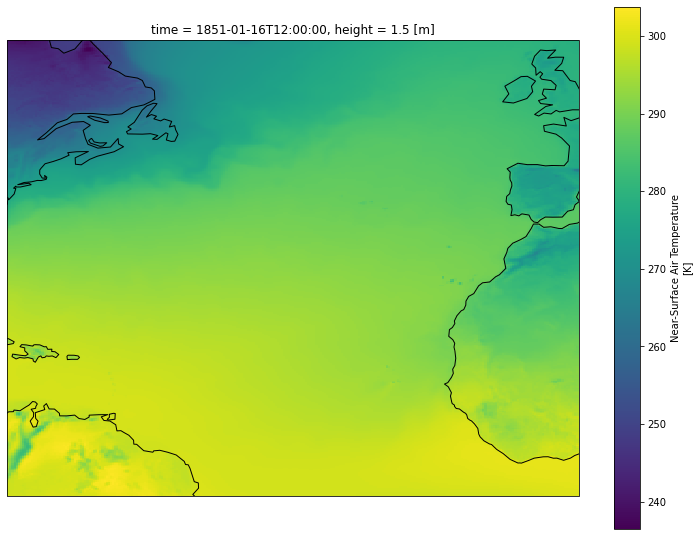

In [16]:
tas_nat = tas_da.sel(lat=slice(0,60), lon=(slice(360-75,360+7.5)) )

fig = plt.figure(figsize=[12.8, 9.6])
ax = plt.axes(projection=ccrs.PlateCarree())
tas_nat.isel(time=0).plot()
ax.coastlines()
plt.draw()

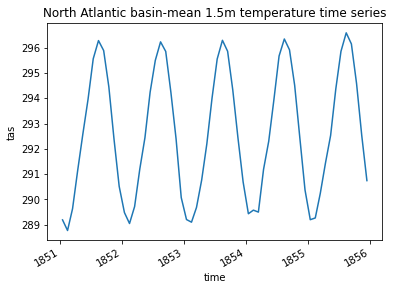

In [22]:
weights = np.cos(np.deg2rad(tas_nat.lat))
tas_nat_weighted = tas_nat.weighted(weights)
tas_nat_mean = tas_nat_weighted.mean(("lon", "lat"))

fig = plt.figure()
tas_nat_mean.plot()
plt.title("North Atlantic basin-mean 1.5m temperature time series")
plt.draw()